In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, SamplingMethod, LossReductionMethod, LayerType, System, plot_loss_df, set_seeds
from deep_macrofin.models.kan import KAN

## Note

For this code to work, currently need to change `deep_macrofin/models/kan/utils.py` line 27 to `sympy.asin`

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

## Region 1

In [3]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid, "batch_size": 1000,
    "num_epochs": 200, "loss_log_interval": 1}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "hidden_units": [1, 2, 1],
        "layer_type": LayerType.KAN,
        "activation_type": ActivationType.SiLU,
    },
    "psi": {
        "hidden_units": [1, 2, 1],
        "layer_type": LayerType.KAN,
        "activation_type": ActivationType.SiLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})

pde_model.add_endog_condition("q", 
                              "q(SV)", 
                              {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "-kappa*r + (kappa**2*r**2 + 1 + 2*ah*kappa)**0.5", {"r": 0.05, "ah": .07, "kappa": 2},
                              label="q_min", weight=100)
pde_model.add_endog_condition("q", 
                              "q(SV)", 
                              {"SV": torch.ones((1, 1))},
                              Comparator.EQ,
                              "-kappa*rho + (kappa**2*rho**2 + 1 + 2*a*kappa)**0.5", {"rho": 0.06, "a": .11, "kappa": 2},
                              label="q_max", weight=100)
pde_model.add_endog_condition("psi", 
                              "psi(SV)", 
                              {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0", {},
                              label="psi_min", weight=100)
pde_model.add_endog_condition("psi", 
                              "psi(SV)", 
                              {"SV": torch.ones((1, 1))},
                              Comparator.EQ,
                              "1", {},
                              label="psi_max", weight=100)

pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$", loss_reduction=LossReductionMethod.SSE)
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * \frac{q * (\psi - \eta)}{\eta * (1-\eta)} = (a - \underline{a}) + (\underline{\delta} - \delta) * q$", loss_reduction=LossReductionMethod.SSE, weight=2)

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_split_kan/region1.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_split_kan", "region1.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan/region1_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan/region1_best.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 1000,
 "num_epochs": 200,
 "lr": 0.001,
 "loss_log_interval": 1,
 "optimizer_type": "AdamW",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State V

c:\Users\yunta\AppData\Local\Programs\Python\Python311\Lib\site-packages\deep_macrofin\models\kan\KAN.py:329: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


====================================Training====================================


Total loss: 0.0018: 100%|██████████| 200/200 [01:46<00:00,  1.87it/s]


training finished, total time :: 106.90777683258057
Best model saved to ./models/BruSan14_log_utility_split_kan_interpret/region1_best.pt if valid
Model saved to ./models/BruSan14_log_utility_split_kan_interpret/region1.pt
Model loaded


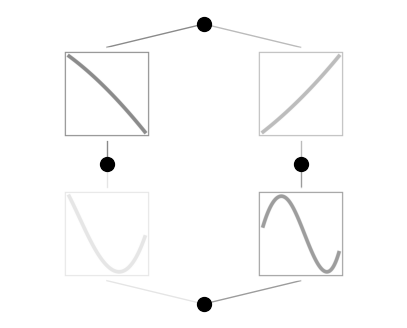

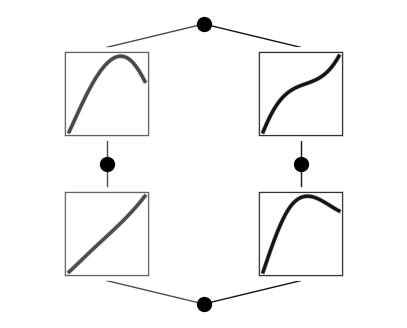

In [4]:
x = pde_model.sample(0)
set_seeds(0)
pde_model.endog_vars["q"].model = KAN([1, 2, 1]).initialize_from_another_model(pde_model.endog_vars["q"].model, x)
pde_model.endog_vars["psi"].model = KAN([1, 2, 1]).initialize_from_another_model(pde_model.endog_vars["psi"].model, x)
if not os.path.exists("./models/BruSan14_log_utility_split_kan_interpret/region1.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_split_kan_interpret", "region1.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan_interpret/region1_best.pt"))
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan_interpret/region1_best.pt"))
pde_model.endog_vars["q"].model(x)
pde_model.endog_vars["psi"].model(x)
pde_model.endog_vars["q"].model.plot()
pde_model.endog_vars["psi"].model.plot()

In [5]:
pde_model.endog_vars["q"].model.auto_symbolic()
formula = pde_model.endog_vars["q"].model.symbolic_formula()[0][0]
print("q:", formula)
pde_model.endog_vars["psi"].model.auto_symbolic()
formula = pde_model.endog_vars["psi"].model.symbolic_formula()[0][0]
print("psi:", formula)

fixing (0,0,0) with gaussian, r2=0.9986394643783569
fixing (0,0,1) with sin, r2=0.9991647005081177
fixing (1,0,0) with x^2, r2=0.9999975562095642
fixing (1,1,0) with 1/x^4, r2=0.9999952912330627
q: 1.16 - 0.2*(-1 + 0.53*exp(-2.37*(0.64 - x_1)**2))**2
fixing (0,0,0) with arcsin, r2=0.9999827146530151
fixing (0,0,1) with cosh, r2=0.9936411380767822
fixing (1,0,0) with gaussian, r2=0.9996294975280762
fixing (1,1,0) with tan, r2=0.9973573088645935
psi: -0.07*tan(1.03*cosh(2.98*x_1 - 1.92) - 8.38) - 0.87 + 2.22*exp(-0.95*(0.38 - asin(1.2*x_1 - 0.47))**2)


## Region 2

In [6]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid, "batch_size": 1000,
    "num_epochs": 200, "loss_log_interval": 1}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q"], configs={
    "q": {
        "hidden_units": [1, 2, 1],
        "layer_type": LayerType.KAN,
        "activation_type": ActivationType.SiLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})

pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (1 - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{1 - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} - \rho$")

pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = a - \iota$", loss_reduction=LossReductionMethod.SSE)
print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_split_kan/region2.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_split_kan", "region2.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan/region2_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan/region2_best.pt"))
    pde_model.eval_model(True)

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 1000,
 "num_epochs": 200,
 "lr": 0.001,
 "loss_log_interval": 1,
 "optimizer_type": "AdamW",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State V

====================================Training====================================


Total loss: 0.0000: 100%|██████████| 200/200 [00:19<00:00, 10.46it/s]


training finished, total time :: 19.114579439163208
Best model saved to ./models/BruSan14_log_utility_split_kan_interpret/region2_best.pt if valid
Model saved to ./models/BruSan14_log_utility_split_kan_interpret/region2.pt
Model loaded


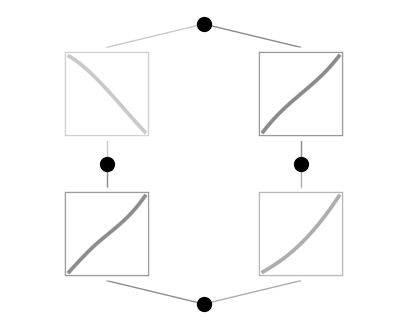

In [8]:
x = pde_model.sample(0)
set_seeds(0)
pde_model.endog_vars["q"].model = KAN([1, 2, 1]).initialize_from_another_model(pde_model.endog_vars["q"].model, x)
if not os.path.exists("./models/BruSan14_log_utility_split_kan_interpret/region2.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_split_kan_interpret", "region2.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan_interpret/region2_best.pt"))
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_split_kan_interpret/region2_best.pt"))
pde_model.endog_vars["q"].model(x)
pde_model.endog_vars["q"].model.plot()

In [9]:
pde_model.endog_vars["q"].model.auto_symbolic()
formula = pde_model.endog_vars["q"].model.symbolic_formula()[0][0]
print("q:", formula)

fixing (0,0,0) with tan, r2=0.9998820424079895
fixing (0,0,1) with arctan, r2=0.999998152256012
fixing (1,0,0) with sin, r2=0.9999962449073792
fixing (1,1,0) with tan, r2=0.9999890923500061
q: 0.04*sin(0.89*tan(1.4*x_1 + 5.6) - 3.47) + 0.02*tan(1.79*atan(1.15*x_1 - 1.34) + 4.14) + 1.09
